# Conjugate GD & Newton conjugate GD

In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import norm
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
x = np.asarray(pd.read_csv('X_cancer', sep = '\s+', header = None))
y = np.asarray(pd.read_csv('y_cancer', sep = '\s+', header = None))
x.shape

(44, 7129)

## Problem  1: Conjugate gradient descent

\begin{equation}
\begin{aligned}
&\text{First calculate the gradient and Hessian matrix:}\\
\\
&\nabla f(\omega) = \sum_{1}^{n}  \frac{e^{-y_i w^T x_i}(-y_i x_i)}{1+e^{-y_i w^T x_i}} + w \\
&\Rightarrow \nabla f(\omega^{(0)}) = \sum_{1}^{n} \frac{-y_i x_i}{2} \\

&\nabla ^2 f(\omega) = \sum_i^n \frac{y_i^2 e^{-y_i w^t x_i}}{(1+e^{-y_i w^t x_i)^2}} x_ix_i^t + I\\
                    &= \sum_i^n \frac{ e^{-y_i w^t x_i}}{(1+e^{-y_i w^t x_i)^2}} x_ix_i^t + I \quad (Since \,\, y_i =1)\\
&\Rightarrow \nabla^2 f(\omega^{(0)}) = \sum_{1}^{n} \frac{1}{4}x_ix_i^T + I\\

&\text{Then denote:}\\
\\
&\nabla ^2 f(\omega^{(0)}) == A \\
&\nabla f(\omega^{(0)}) == b\\
\\
&\text{So the objective function can be re-written as:}\\
\\
&A\Delta x_{nt} = b
\end{aligned}
\end{equation}


In [3]:
b = ((y * x) / 2).sum(axis = 0).reshape(-1, 1)
yx = 1/2 * y * x
A = yx.T @ yx + np.identity(x.shape[1])
A.shape, b.shape

((7129, 7129), (7129, 1))

In [4]:
def conjugateDescent(A, b):
    '''
    return a 7129*1 vector
    '''
    x = np.zeros_like(b)
    rk = b - A@x
    norm_r0 = norm(rk)
    p = rk
    k = 0
    while True:
        a = (rk.T @ rk) / (p.T @ A @ p)
        x = x + a * p
        r_back = rk
        rk = rk - a * A @ p
        k += 1
        # print(norm(rk) / norm_r0)
        if norm(rk) / norm_r0 <= 0.001:
            break
        beta = rk.T @ rk / (r_back.T @ r_back)
        p = rk + beta * p
    return k, x

In [5]:
_, deltaX = conjugateDescent(A, b)
norm(deltaX)
deltaX

array([[-4.11859629e-05],
       [ 2.27818495e-03],
       [ 2.37479573e-03],
       ...,
       [-9.36992854e-04],
       [-2.34752519e-03],
       [ 1.29771996e-03]])

Only after 12 iterations, the result has been converged. And the norm of $\Delta x_{nt}$ is $0.17795908199634294$


## Problem 2: Newton-GC

In [6]:
def gradient(w):
    ''' 
    function to calculate the gradient
    return: a 7192 * 1 column vector
    '''
    ew = -y * (x @ w)
    numerator = -y * (np.exp(ew) * x)
    denominator = 1 + np.exp(ew)
    return (numerator / denominator).sum(axis = 0).reshape(-1, 1) + w

def hessian(w):
    '''
    function calculate the hessian given w
    return: A 7192*7192 matrix
    '''
    ew = -y * (x @ w)
    l = np.exp(ew) / (1 + np.exp(ew))**2
    return (l * x).T @ x + np.identity(x.shape[1])

def f(w):
    '''
    Calculate the function value
    '''
    ew = -y * (x @ w)
    return np.log(1 + np.exp(ew)).sum(axis = 0) + 0.5 * (norm(w)**2)

def newtonGC(max_iter = 20):
    ls = []
    w = np.zeros((7129,1))
    step = 0
    for i in tqdm(range(max_iter)):
        step += 1
        b = -gradient(w)
        A = hessian(w)
        _, dx =conjugateDescent(A,b)

        a = 1
        while f(w + a * dx) > f(w) + (0.01 * a * b.T @ dx):
            a = a/2
        if f(w + a*dx) == f(w):
            print('\nAlgorithm has been converged in {} steps'.format(step-1))
            break
        w = w + a * dx
        ls.append(f(w)[0])

    return w, ls

In [7]:
w, ls = newtonGC(max_iter = 20)

65%|██████▌   | 13/20 [00:24<00:13,  1.93s/it]
Algorithm has been converged in 13 steps


Only after 13 iterations, the result has been convergered. And the value of the function is 0.21581710458045578. Then I get the log-error plot as below.

In [8]:
print('Fucntion values:\n', ls)

Fucntion values:
 [5.649030152213916, 1.9446091403117802, 0.7633730493121259, 0.37120186813859, 0.251603959290672, 0.22173895732620658, 0.21633475050316586, 0.21583123073122984, 0.21581716220457264, 0.21581710458423897, 0.21581710458045633, 0.21581710458045628, 0.2158171045804559]


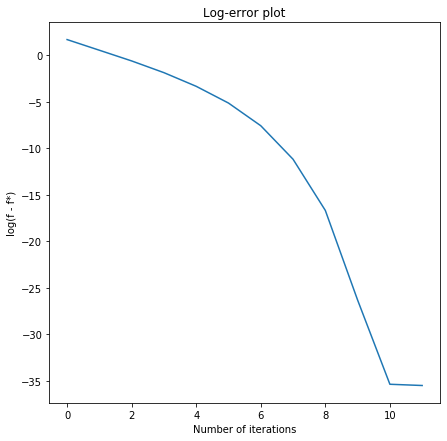

In [9]:
f_min = ls[-1]
pl = ls - f_min
fig, ax = plt.subplots(1, figsize = (7,7))
ax.plot(np.log(pl[0:-1]))
ax.set_xlabel('Number of iterations')
ax.set_ylabel('log(f - f*)')
ax.set_title('Log-error plot')
plt.show()